# Load libraries 

In [1]:
#load libraries 
import sys,pandas as pd, matplotlib , matplotlib.pyplot as plt, matplotlib.lines , numpy as np, math, pylab
#import ROOT
#from ROOT import TFile

import root_pandas
%matplotlib inline

#presets for plot style
from scipy.constants import golden
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (7, 7/golden),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

from scipy.optimize import curve_fit


Welcome to JupyROOT 6.23/01


# Load tuple files
The following will automatically download the files from https://userweb.jlab.org/~spaul/sidis_tuple_examples, if they are not already downloaded.  

In [2]:
import urllib.request, os

for filename in "example_mc_large.root",:
    if not (filename in os.listdir(".")):
        url = 'https://userweb.jlab.org/~spaul/sidis_tuples_examples/' +filename
        urllib.request.urlretrieve(url, filename)
        print("downloaded file from " + url)
    else:
        print("found file: " + filename + ",\t no need to re-download")
print("done downloading files")

found file: example_mc_large.root,	 no need to re-download
done downloading files


Now load the tuples from the files.

In [3]:
#electrons: events with at least one electron which passes DIS event selection cuts
#hadrons: events with at least one electron (passing cuts above) and at least one charged hadron
#dihadrons: events with at least one electron and two charged hadrons, one of which is a "leading" pion, (ie, z>0.5)

mc_electrons = root_pandas.read_root("example_mc_large.root", "electrons")
mc_hadrons = root_pandas.read_root("example_mc_large.root", "hadrons")
mc_dihadrons = root_pandas.read_root("example_mc_large.root", "dihadrons")

In [4]:
#apply cuts in order to match the event selection used by Orlando
mc_hadrons = mc_hadrons.query("h_p>1.25 and h_p<5 and h_th>3.14159/180*5 and h_th<3.14159/180*35 and y<0.8")

In [6]:
#print the number of entries in each tuple
print("mc electrons\tlength =", len(mc_electrons))
print("mc hadrons\tlength =", len(mc_hadrons))
print("mc dihadrons\tlength =", len(mc_dihadrons))

mc electrons	length = 2180510
mc hadrons	length = 213511
mc dihadrons	length = 10132


In [16]:
def binspace(df, query, min, max, nbins):
    ls = np.linspace(min,max,nbins)
    return [df.query("%s> %s and %s < %s" %(query, mn, query, mx)) for mn,mx in zip(ls[:-1],ls[1:])]

def getmeanstd(df, query):
    a = df.eval(query)
    x0, sigma = np.mean(a), np.std(a)
    nbins = 50
    bins = binspace(df,query, x0-3*sigma, x0+3*sigma, nbins)
    x = np.linspace(x0-3*sigma, x0+3*sigma, nbins-1)
    x += (x[1]-x[0])/2
    y = [len(bin) for bin in bins]
    del bins
    def gaus(x,a,x0,sigma):
        return a*np.exp(-(x-x0)**2/(2*sigma**2))
    
    popt,pcov = curve_fit(gaus,x,y,p0=[1,x0,sigma])

    return popt[1],abs(popt[2])

# Plots for the electrons tuple

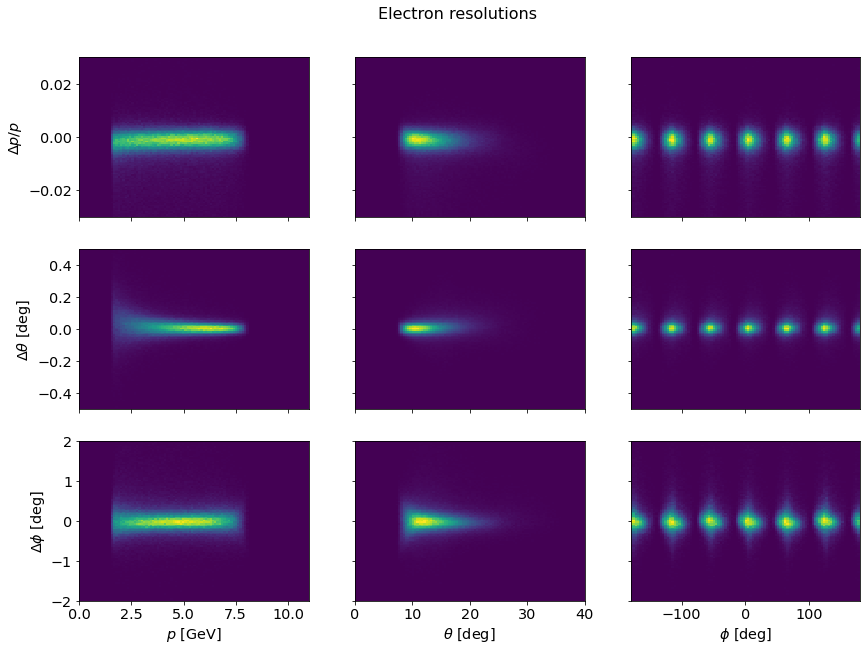

In [19]:
df = mc_electrons.query("e_truth_p != 0 and e_p !=0")

fig,axs = plt.subplots(3,3, figsize=(14,10),sharey='row',sharex='col')
for i,(xvar,xrange) in enumerate(zip(("e_truth_p","e_truth_th*180/3.14159","e_truth_ph*180/3.14159"),
                           ((0,11),(0,40),(-180,180)))):
    axs[0][i].hist2d(df.eval(xvar), (df.e_p-df.e_truth_p)/df.e_p,bins=(100,100), range=(xrange,(-0.03,0.03)))
    axs[1][i].hist2d(df.eval(xvar), (df.e_th-df.e_truth_th)*180/np.pi,bins=(100,100), range=(xrange,(-0.5,0.5)))
    axs[2][i].hist2d(df.eval(xvar), (df.e_ph-df.e_truth_ph)*180/np.pi,bins=(100,100), range=(xrange,(-2,2)))

axs[0][0].set_ylabel("$\\Delta p/p$")
axs[1][0].set_ylabel("$\\Delta\\theta$ [deg]")
axs[2][0].set_ylabel("$\\Delta\\phi$ [deg]")
axs[2][0].set_xlabel("$p$ [GeV]")
axs[2][1].set_xlabel("$\\theta$ [deg]")
axs[2][2].set_xlabel("$\\phi$ [deg]")
fig.suptitle('Electron resolutions', fontsize=16, verticalalignment='top',y=0.95)
fig.savefig("../images/electron_resolutions_2d.pdf")
plt.show()

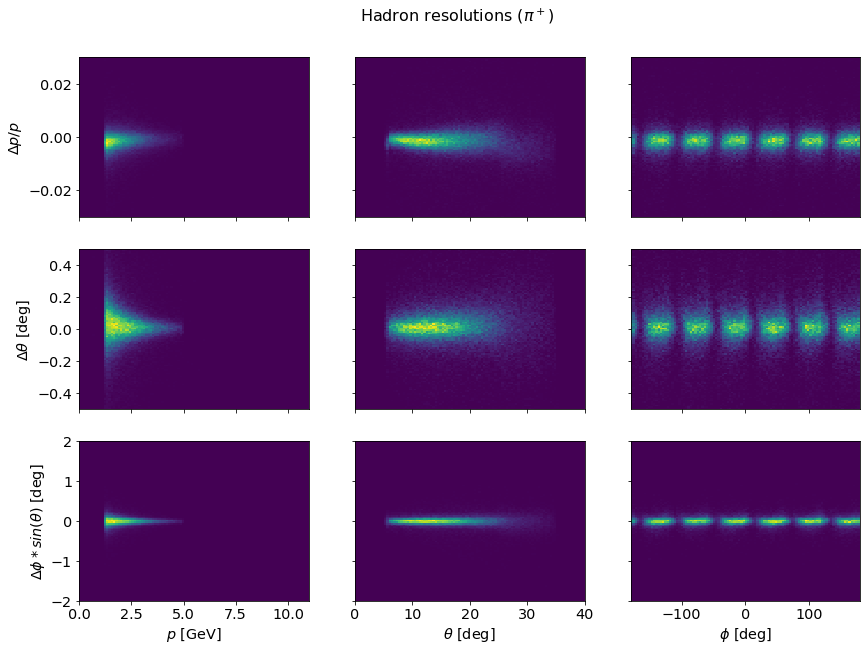

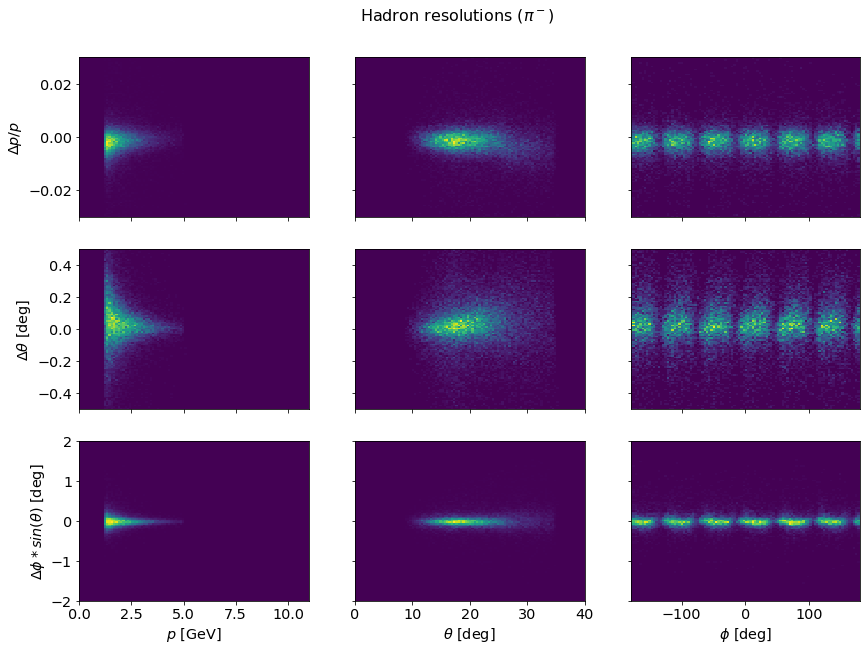

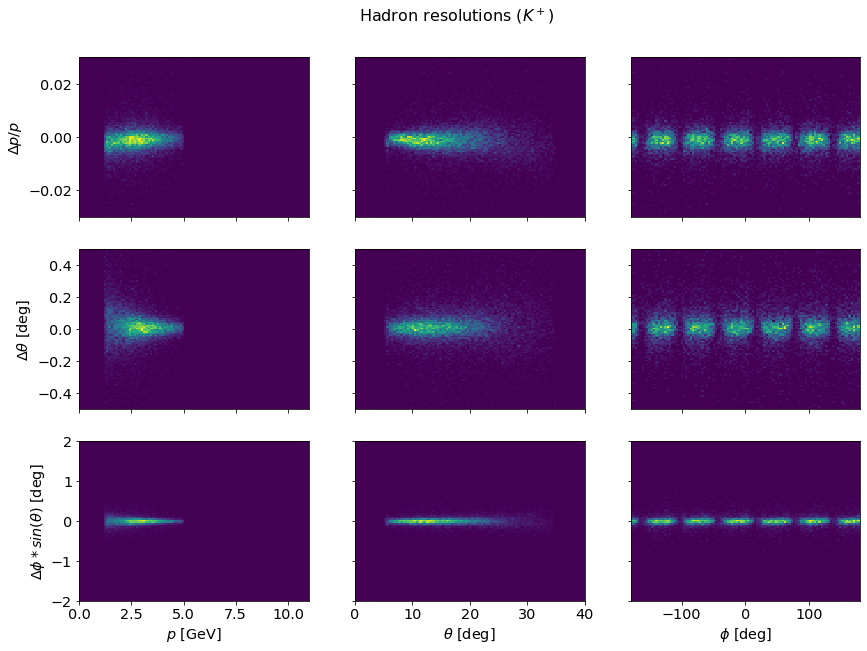

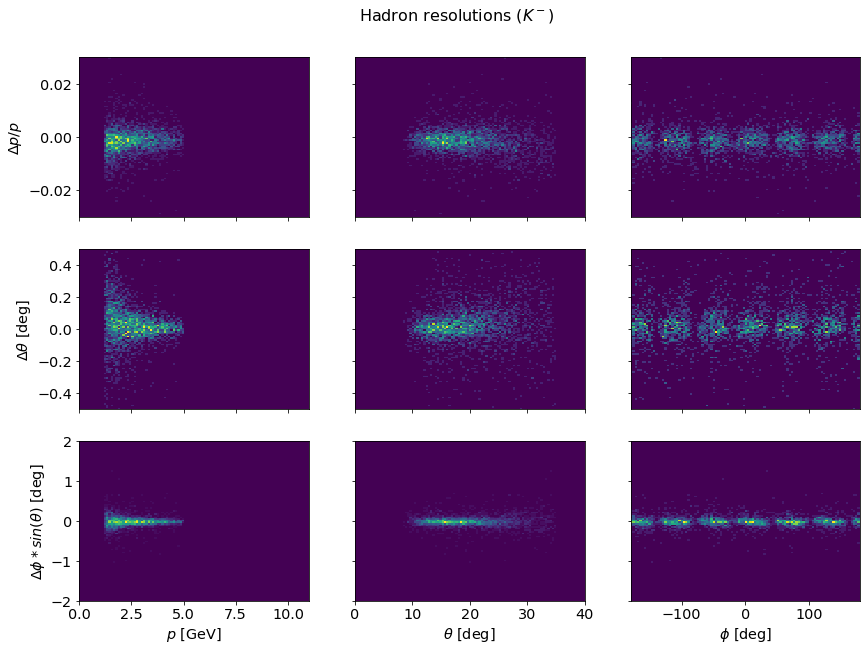

In [20]:
for pid, name in (211, "$\\pi^+$"),(-211, "$\\pi^-$"),(321, "$K^+$"),(-321, "$K^-$"):
    df = mc_hadrons.query("h_truth_p != 0 and h_p !=0 and h_truth_pid == %s"% pid)
    fig,axs = plt.subplots(3,3, figsize=(14,10),sharey='row',sharex='col')
    for i,(xvar,xrange) in enumerate(zip(("h_truth_p","h_truth_th*180/3.14159","h_truth_ph*180/3.14159"),
                               ((0,11),(0,40),(-180,180)))):
        axs[0][i].hist2d(df.eval(xvar), (df.h_p-df.h_truth_p)/df.h_p,bins=(100,100), range=(xrange,(-0.03,0.03)))
        axs[1][i].hist2d(df.eval(xvar), (df.h_th-df.h_truth_th)*180/np.pi,bins=(100,100), range=(xrange,(-0.5,0.5)))
        axs[2][i].hist2d(df.eval(xvar), (df.h_ph-df.h_truth_ph)*180/np.pi*np.sin(df.h_th),bins=(100,100), range=(xrange,(-2,2)))

    axs[0][0].set_ylabel("$\\Delta p/p$")
    axs[1][0].set_ylabel("$\\Delta\\theta$ [deg]")
    axs[2][0].set_ylabel("$\\Delta\\phi*sin(\\theta)$ [deg]")
    axs[2][0].set_xlabel("$p$ [GeV]")
    axs[2][1].set_xlabel("$\\theta$ [deg]")
    axs[2][2].set_xlabel("$\\phi$ [deg]")
    fig.suptitle('Hadron resolutions (%s)' % name, fontsize=16, verticalalignment='top',y=0.95)
    name = name.replace("$","").replace("\\","").replace("^","").replace("+","p").replace("-","m")
    fig.savefig("../images/"+ name+"_resolutions_2d.pdf")
    plt.show()

[-0.12376490852614602, -0.04711638655986807, -0.0002832771515999119, 0.045215576973077994, 0.031112884208896647, 0.006032848627817589, 0.05431461904053096]
[0.28296363124722945, 0.2626669058643475, 0.254665697410488, 0.24842058294398114, 0.23521816788839361, 0.2229551079303602, 0.2215565806622037]
[-0.0553804016370259, -0.0012392314921850557, -0.030418836632702232, -0.06170816409677505, -0.04275595791405628, -0.04004556786888324, 0.03201856306551659, -0.025564965852546362, 0.0654710884877259, 0.03032412746692355, -0.13725339092293207, -0.28080254078739536, -0.27862003563925797, -0.3162923407100621, -0.29776405921127763]
[0.19307387304689128, 0.16920723816496194, 0.1897044494900611, 0.2129181789724399, 0.24179834152555577, 0.27007619758141904, 0.3170422567493977, 0.3234283735671278, 0.36215433312903766, 0.3964347561488709, 0.48034611135177013, 0.4884898459738222, 0.506848802058232, 0.5591011877414087, 0.5322893473578814]
[-0.020502317027448543, -0.004207340419020418, -0.0242233382021759

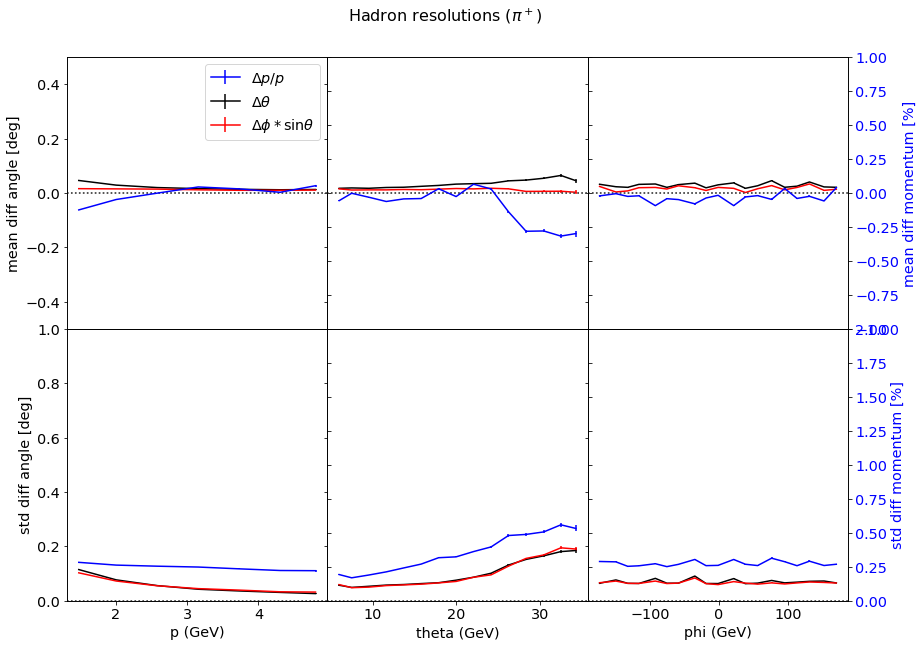

[-0.14217352828013063, -0.0437797398720735, 0.012361820950132609, 0.009451518929802482, 0.03449674923836315, 0.08436070730329677, 0.07716830104858327]
[0.37427599730363204, 0.322701668280923, 0.29717365406559104, 0.2926689831674651, 0.26571338973038083, 0.26536766070846945, 0.31689278564971773]
[0.009260788767252873, -0.03987948642223275, -0.05937194135247272, -0.03346117142145723, -0.046217876349099005, 0.002549601745700714, -0.02926619616116139, -0.01912626720332125, -0.1675953200512878, -0.2702450579143154, -0.3294330542958305, -0.28966837688361313, -0.3730007469216577]
[0.22982716502143524, 0.26306385400479343, 0.2527480839317979, 0.28094715349928795, 0.28885881435748, 0.31809467261988383, 0.33127576560797534, 0.37633844226696683, 0.4400113180655612, 0.4619360214457207, 0.48915212870528496, 0.5119830887219133, 0.5668933365802359]
[-0.07576140695677952, -0.06882772151434198, -0.06841872658917526, -0.04814550120076868, -0.04744285576495478, -0.03959009108944965, -0.05620258482993951,

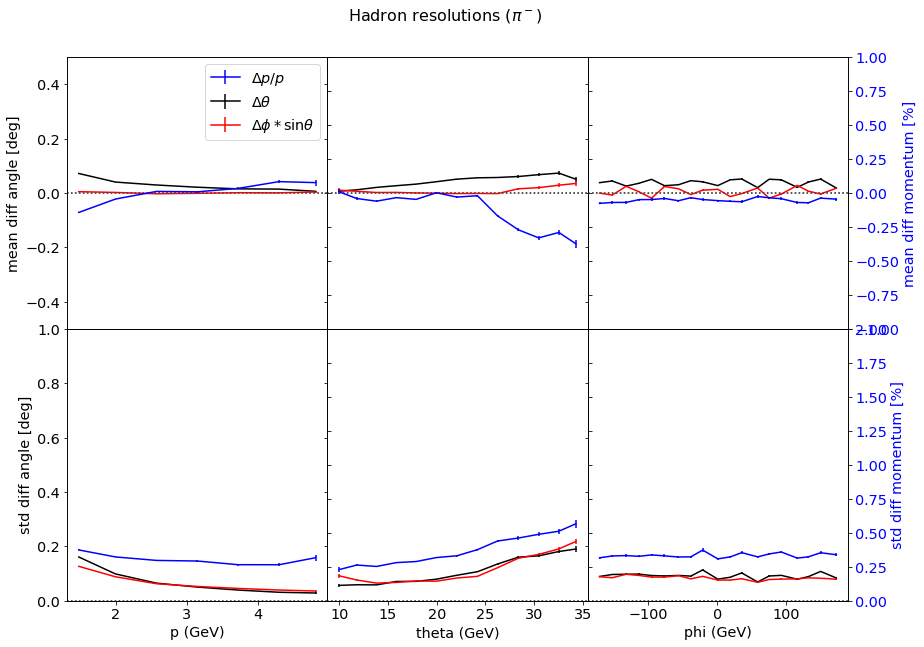

In [22]:
for pid, name,charge in (211, "$\\pi^+$","+"),(-211, "$\\pi^-$","-"):#,(321, "$K^+$"),(-321, "$K^-$"):
    df = mc_hadrons.query("h_truth_p != 0 and h_p !=0 and h_truth_pid == %s"% pid)
    fig,axs = plt.subplots(2,3, figsize=(14,10),sharex='col',sharey='row')
    twinx = [[a.twinx() for a in ax] for ax in axs]
    fig.subplots_adjust(wspace=0, hspace=0)
    
    for i,(xvar,xrange) in enumerate(zip(("h_truth_p","h_truth_th*180/3.14159","h_truth_ph*180/3.14159"),
                               ((0,11),(0,40),(-180,180)))):
        for j,(yvar,color,label) in enumerate(zip(("(h_p-h_truth_p)/h_truth_p*100","(h_th-h_truth_th)*180/3.14159",
                                 "((h_ph-h_truth_ph)+(h_ph-h_truth_ph >3.14159)*-2*3.14159 +(h_ph-h_truth_ph <-3.14159)*2*3.14159)*180/3.14159*sin(h_truth_th)"),
                                      "bkr","$\\Delta p/p$;$\\Delta\\theta$;$\\Delta\\phi*\\sin\\theta$".split(";"))):
            x=[];y1=[];dy1=[];y2=[];dy2=[]
            for bin in binspace(df, xvar, xrange[0],xrange[1], 20):
                n = len(bin)
                if(n < 20):
                    continue;
                
                mean,std = getmeanstd(bin, yvar)
                x.append(np.mean(bin.eval(xvar)))
                y1.append(mean)
                dy1.append(std/np.sqrt(n))  
                y2.append(std)
                dy2.append(std/np.sqrt(n))
                
            if j!=0: # plot momentum values on a different scale
                axs[0][i].errorbar(x,y1,dy1,color=color,label=label)
                axs[1][i].errorbar(x,y2,dy2,color=color,label=label)
            else :
                #for the legend only
                axs[0][i].errorbar([],[],[],color=color,label=label)
                print(y1)
                twinx[0][i].errorbar(x,y1,dy1,color=color,label=label)
                print(y2)
                twinx[1][i].errorbar(x,y2,dy2,color=color,label=label)
        
        axs[0][i].axhline(0, color='0.3',linestyle=':')
        axs[1][i].axhline(0, color='0.3',linestyle=':')
        twinx[0][i].axhline(0, color='0.3',linestyle=':')
        twinx[1][i].axhline(0, color='0.3',linestyle=':')
    twinx[0][2].tick_params(axis='y', labelcolor='b')
    twinx[1][2].tick_params(axis='y', labelcolor='b')
    twinx[0][2].set_ylabel("mean diff momentum [%]",color='b')
    twinx[1][2].set_ylabel("std diff momentum [%]",color='b')
    for i in range(3):
        twinx[0][i].set_ylim(-1.0, 1.0)
        twinx[1][i].set_ylim(0, 2)
    axs[0][0].set_ylim(-0.5,0.5)
    axs[0][0].set_ylabel("mean diff angle [deg]")
    axs[1][0].set_ylim(0,1)
    axs[1][0].set_ylabel("std diff angle [deg]")
    
    twinx[0][0].get_shared_y_axes().join(twinx[0][1], twinx[0][2])
    twinx[1][0].get_shared_y_axes().join(twinx[1][1], twinx[1][2])
    axs[0][0].get_shared_y_axes().join(axs[0][1], axs[0][2])
    axs[1][0].get_shared_y_axes().join(axs[1][1], axs[1][2])
    
    axs[1][0].set_xlabel("p (GeV)")
    axs[1][1].set_xlabel("theta (GeV)")
    axs[1][2].set_xlabel("phi (GeV)")
    
    axs[0][0].legend()
    
    # Turn off internal tick labels
    twinx[0][0].set_yticklabels([])
    twinx[0][1].set_yticklabels([])
    twinx[1][0].set_yticklabels([])
    twinx[1][1].set_yticklabels([])
    fig.suptitle('Hadron resolutions (%s)' % name, fontsize=16, verticalalignment='top',y=0.95)
    fig.savefig("../images/pi%s_resolutions.pdf"% charge)
    plt.show()

[-0.11351238157463935, 0.056200933372288354, 0.167828020011124, 0.20843530124690746, 0.22643640087737266, 0.25182039472309115, 0.2565787548500793, 0.2584065916449186, 0.2409110645416816, 0.2186513741032724, 0.1768674332739403, 0.08734989019748489, -0.15743879006033787]
[0.36160024054611933, 0.36931636876542495, 0.40988428781572916, 0.39046278669591405, 0.36652193956047163, 0.3640861162944503, 0.3580939727868062, 0.3515489495928557, 0.3414502549559121, 0.3263451995687147, 0.3038408254061133, 0.3010619092873772, 0.26675324957589697]
[0.012071509914787174, 0.11798171228590472, 0.1817643703280407, 0.27215002905917407, 0.24751324413024928, 0.23331521697502067, 0.2211910079100308, 0.21076985841266452, 0.2351610543670787, 0.1672600701661294, 0.06735572680502089, -0.03848108541887161, -0.06211287790964713, -0.2308983927582872, -0.31968558767157085]
[0.30285844826266084, 0.2856057240610062, 0.31542951518945983, 0.36330617133884985, 0.3768344122732662, 0.3853127502511281, 0.4213507179525295, 0.4

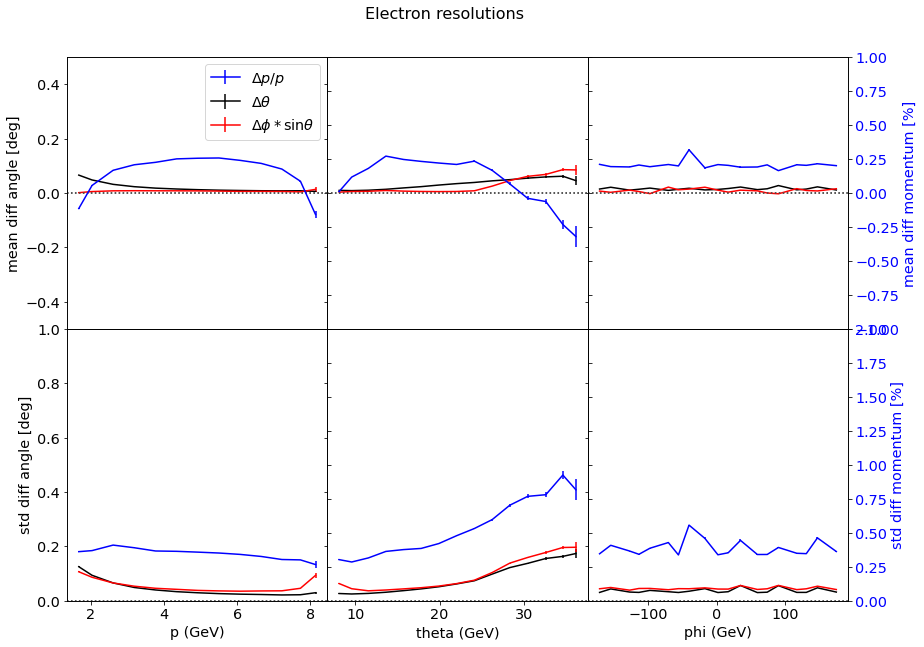

In [24]:
#same for electrons
df = mc_electrons.query("e_truth_p != 0 and e_p !=0 and e_truth_pid == 11")
fig,axs = plt.subplots(2,3, figsize=(14,10),sharex='col',sharey='row')
twinx = [[a.twinx() for a in ax] for ax in axs]
fig.subplots_adjust(wspace=0, hspace=0)

for i,(xvar,xrange) in enumerate(zip(("e_truth_p","e_truth_th*180/3.14159","e_truth_ph*180/3.14159"),
                           ((0,11),(0,40),(-180,180)))):
    for j,(yvar,color,label) in enumerate(zip(("(e_p-e_truth_p)/e_truth_p*100","(e_th-e_truth_th)*180/3.14159",
                             "((e_ph-e_truth_ph)+(e_ph-e_truth_ph >3.14159)*-2*3.14159 +(e_ph-e_truth_ph <-3.14159)*2*3.14159)*180/3.14159*sin(e_truth_th)"),
                                  "bkr","$\\Delta p/p$;$\\Delta\\theta$;$\\Delta\\phi*\\sin\\theta$".split(";"))):
        x=[];y1=[];dy1=[];y2=[];dy2=[]
        for bin in binspace(df, xvar, xrange[0],xrange[1], 20):
            n = len(bin)
            if(n < 20):
                continue;

            mean,std = getmeanstd(bin, yvar)
            x.append(np.mean(bin.eval(xvar)))
            y1.append(mean)
            dy1.append(std/np.sqrt(n))  
            y2.append(std)
            dy2.append(std/np.sqrt(n))

        if j!=0: # plot momentum values on a different scale
            axs[0][i].errorbar(x,y1,dy1,color=color,label=label)
            axs[1][i].errorbar(x,y2,dy2,color=color,label=label)
        else :
            #for the legend only
            axs[0][i].errorbar([],[],[],color=color,label=label)
            print(y1)
            twinx[0][i].errorbar(x,y1,dy1,color=color,label=label)
            print(y2)
            twinx[1][i].errorbar(x,y2,dy2,color=color,label=label)

    axs[0][i].axhline(0, color='0.3',linestyle=':')
    axs[1][i].axhline(0, color='0.3',linestyle=':')
    twinx[0][i].axhline(0, color='0.3',linestyle=':')
    twinx[1][i].axhline(0, color='0.3',linestyle=':')
twinx[0][2].tick_params(axis='y', labelcolor='b')
twinx[1][2].tick_params(axis='y', labelcolor='b')
twinx[0][2].set_ylabel("mean diff momentum [%]",color='b')
twinx[1][2].set_ylabel("std diff momentum [%]",color='b')
for i in range(3):
    twinx[0][i].set_ylim(-1, 1)
    twinx[1][i].set_ylim(0, 2)
axs[0][0].set_ylim(-0.5,0.5)
axs[0][0].set_ylabel("mean diff angle [deg]")
axs[1][0].set_ylim(0,1)
axs[1][0].set_ylabel("std diff angle [deg]")

twinx[0][0].get_shared_y_axes().join(twinx[0][1], twinx[0][2])
twinx[1][0].get_shared_y_axes().join(twinx[1][1], twinx[1][2])
axs[0][0].get_shared_y_axes().join(axs[0][1], axs[0][2])
axs[1][0].get_shared_y_axes().join(axs[1][1], axs[1][2])

axs[1][0].set_xlabel("p (GeV)")
axs[1][1].set_xlabel("theta (GeV)")
axs[1][2].set_xlabel("phi (GeV)")

axs[0][0].legend()

# Turn off internal tick labels
twinx[0][0].set_yticklabels([])
twinx[0][1].set_yticklabels([])
twinx[1][0].set_yticklabels([])
twinx[1][1].set_yticklabels([])
fig.suptitle('Electron resolutions', fontsize=16, verticalalignment='top',y=0.95)
fig.savefig("../images/electron_resolutions.pdf")
plt.show()